## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [ ]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),          # Recency
                                                     'customer_id': lambda x: len(x),                           # Frequency
                                                     'tran_amount': lambda x: x.sum()})                     # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [ ]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [ ]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                                       # Frequency
                                                     'tran_amount': lambda x: x.sum(),                                    # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})               # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [ ]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## **Calculating response rate**

In [ ]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


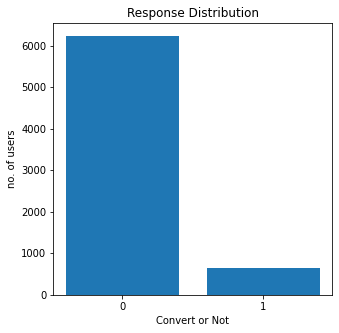

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


In [ ]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


## **Creating train and test dataset**

In [ ]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [ ]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

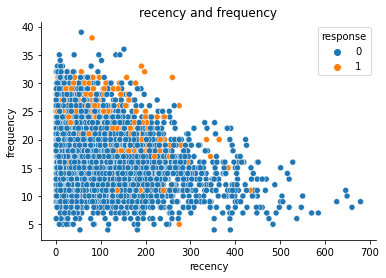

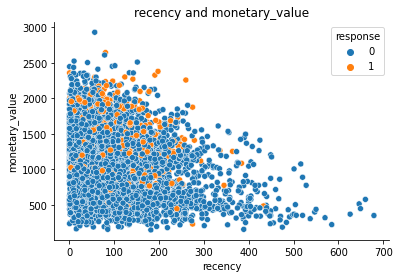

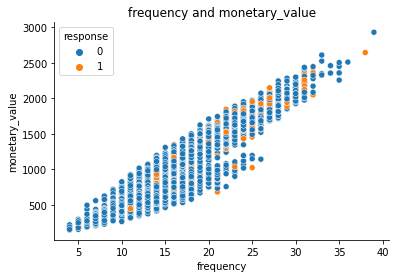

In [ ]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

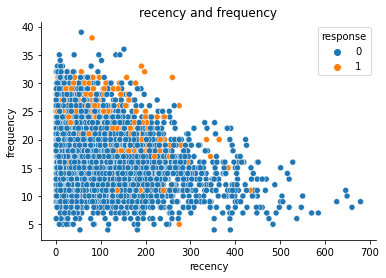

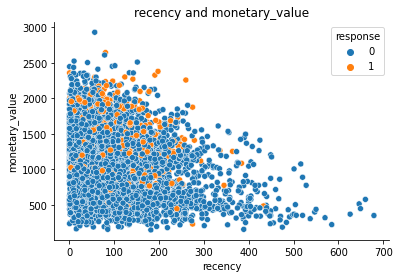

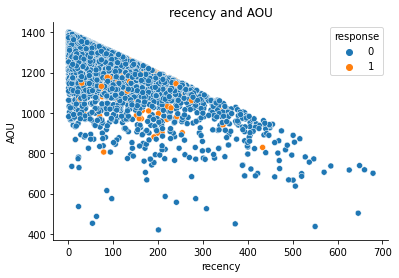

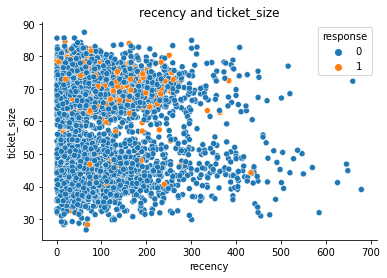

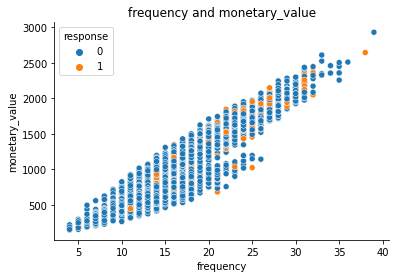

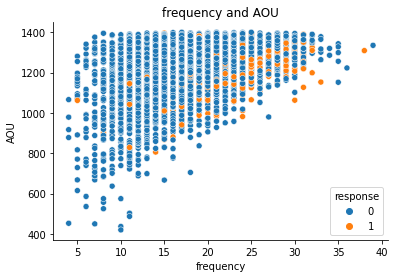

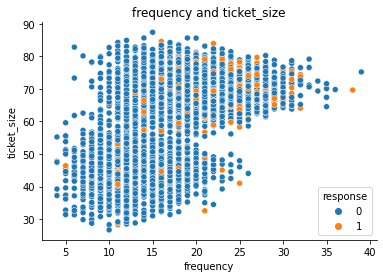

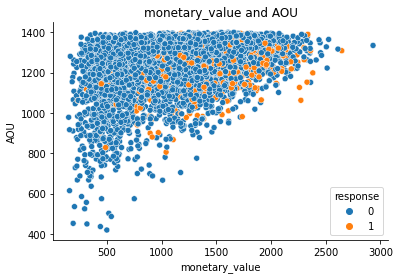

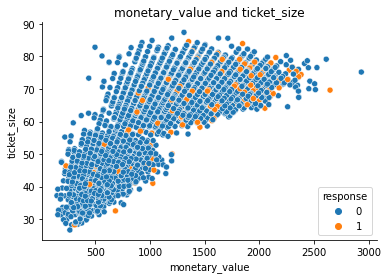

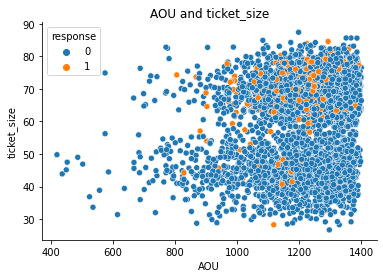

In [ ]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [ ]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [ ]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066



In [ ]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.63      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.63      0.70      2066



## **XGBoost**

In [ ]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.3,    #change 0.01 >> 0.3
 n_estimators=100,
 max_depth=20,        #change 2 >> 20
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.562636
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.636721
[2]	validation_0-auc:0.639358
[3]	validation_0-auc:0.644874
[4]	validation_0-auc:0.663385
[5]	validation_0-auc:0.667483
[6]	validation_0-auc:0.662065
[7]	validation_0-auc:0.674141
[8]	validation_0-auc:0.681083
[9]	validation_0-auc:0.681651
[10]	validation_0-auc:0.68425
[11]	validation_0-auc:0.685515
[12]	validation_0-auc:0.687809
[13]	validation_0-auc:0.692853
[14]	validation_0-auc:0.697338
[15]	validation_0-auc:0.701752
[16]	validation_0-auc:0.705411
[17]	validation_0-auc:0.708047
[18]	validation_0-auc:0.710109
[19]	validation_0-auc:0.711633
[20]	validation_0-auc:0.711728
[21]	validation_0-auc:0.712254
[22]	validation_0-auc:0.708893
[23]	validation_0-auc:0.708511
[24]	validation_0-auc:0.709084
[25]	validation_0-auc:0.709794
[26]	validation_0-auc:0.710745
Stopping. Best iteration:
[21]	validation_0-auc:0.712254

training set
              

In [ ]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.3,        #change 0.01 >> 0.3
 n_estimators=100,
 max_depth=20,             #change 2 >> 20
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.616022
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.623804
[2]	validation_0-auc:0.627667
[3]	validation_0-auc:0.63077
[4]	validation_0-auc:0.634964
[5]	validation_0-auc:0.633452
[6]	validation_0-auc:0.643062
[7]	validation_0-auc:0.648257
[8]	validation_0-auc:0.652092
[9]	validation_0-auc:0.654402
[10]	validation_0-auc:0.655087
[11]	validation_0-auc:0.654912
[12]	validation_0-auc:0.652753
[13]	validation_0-auc:0.650833
[14]	validation_0-auc:0.651853
[15]	validation_0-auc:0.654077
Stopping. Best iteration:
[10]	validation_0-auc:0.655087

training set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4389
           1       0.99      0.98      0.99      4389

    accuracy                           0.99      8778
   macro avg       0.99      0.99      0.99      8778
weighted avg       0.99      0.99      0.99      8778

test set
              preci

In [ ]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [ ]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 8)],     #change range (4,7) >> (4,8)
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=60)      #Random state from 42 >> 60
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score), 'F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.1min finished


In [ ]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test_clv, predictions)))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7089054675375633
Accuracy: 0.6079380445304937
[[1089  759]
 [  51  167]]
test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1848
           1       0.18      0.77      0.29       218

    accuracy                           0.61      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.87      0.61      0.68      2066



In [ ]:
print(xgb_model_clv_GS.best_params_)
#xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7ff39fc294d0>}
